Compare simulation and analytic result for short dipole beam with linearly polarized source at zenith.

In [1]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from croissant.healpix import grid2healpix
import faraday as fd

#%matplotlib notebook

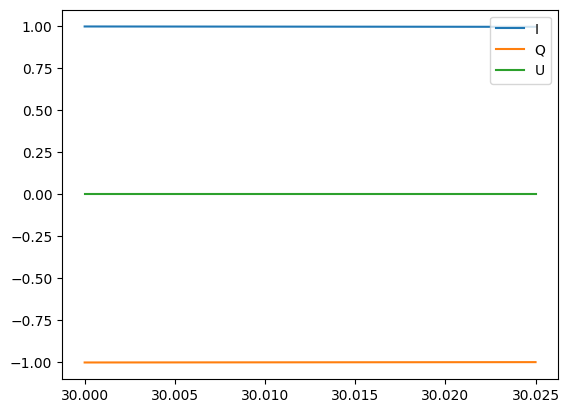

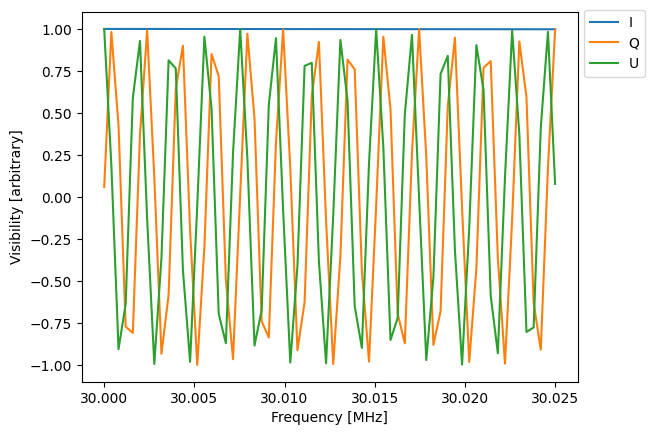

In [2]:
FREQ = 30  # minimum frequency in MHz
NCHANS = 64  # frequency channels
NSIDE = 128
THETA_MAX = 5  # extent of point src in degrees
RM = 250  # rotation measure

frequencies = np.linspace(0, 25/1e3, NCHANS) + FREQ  # 64 channels of 390 Hz width
c = 299792458  # m / s

#alpha0 = -RM * (c/23e9)**2  # ref freq where alpha is 0
alpha0 = 0

def stokes_analytic(frequencies=frequencies, faraday=True, rm=RM, alpha0=alpha0):
    wave = c / (frequencies * 1e6)  # wavelength in m
    if faraday:
        arg = 2 * (rm * wave**2 + alpha0)
    else:
        arg = 2 * alpha0 * np.ones(frequencies.size)
    s = np.array([np.ones(frequencies.size), -np.cos(arg), -np.sin(arg)])
    return s * (frequencies[None]/frequencies.min())**(-2.5)

stokes = stokes_analytic(faraday=False)
stokes_rot = stokes_analytic(faraday=True)

plt.figure()
plt.plot(frequencies, stokes[0], label="I")
plt.plot(frequencies, stokes[1], label="Q")
plt.plot(frequencies, stokes[2], label="U")
plt.legend()
plt.show()


plt.figure()
plt.plot(frequencies, stokes_rot[0], label="I")
plt.plot(frequencies, stokes_rot[1], label="Q")
plt.plot(frequencies, stokes_rot[2], label="U")
plt.legend(bbox_to_anchor=[1.15, 1.025])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Visibility [arbitrary]")
plt.show()

In [3]:
beam = fd.ShortDipole(NSIDE, frequency=FREQ)
sky = fd.Sky.zeros(NSIDE, freq=FREQ)
sky.add_point_source(extent=THETA_MAX)  # 5 deg source at zenith
pix = sky.del_dark_pixels()  # pixels to keep
beam.del_pix(pix)
sky.power_law(frequencies, -2.5)
sky.apply_faraday(RM)


sim = fd.Simulator(beam, sky)
sim.run(channelize=False)

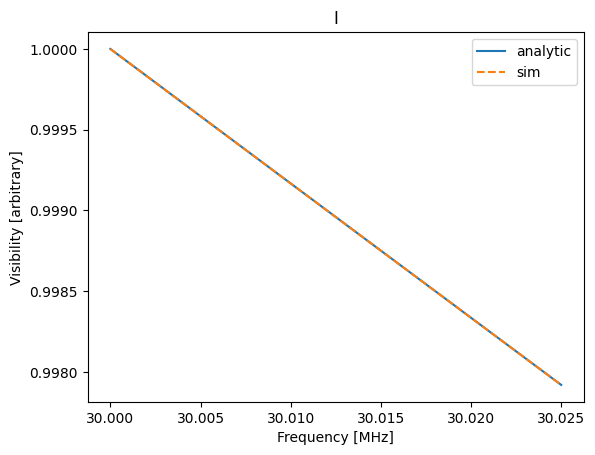

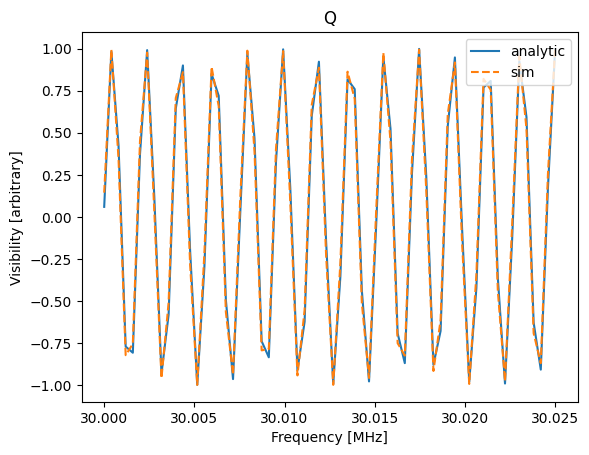

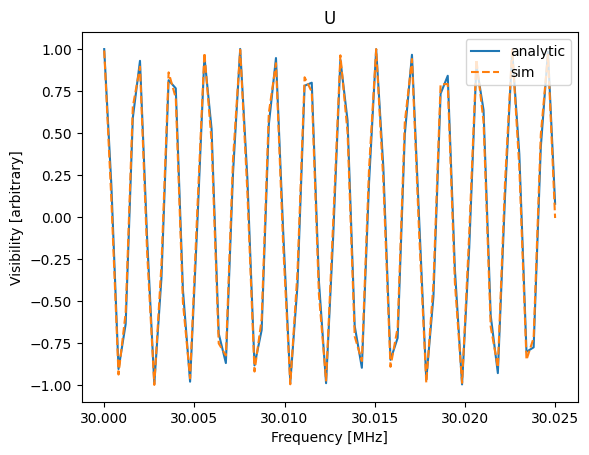

In [5]:
labels = ["I", "Q", "U"]
for i in range(3):
    plt.figure()
    plt.plot(frequencies, stokes_rot[i], label="analytic")
    plt.plot(frequencies, sim.stokes_rot[i], label="sim", ls="--")
    plt.legend(loc="upper right")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Visibility [arbitrary]")
    plt.title(labels[i])
    plt.show()